In [1]:
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import scipy
import numpy as np
import anndata
import h5py
import tqdm
from os.path import join as pjoin
import snapatac2 as snap
import pybedtools
import anndata as ad
import scanpy as sc

root_directory = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup'


### subsetting the astro_atac_h5ads

In [ ]:
## atac data
file_path = os.path.join(root_directory, 'concatenated.h5ads') #same as "../h5ad/concatenated.h5ads"
data = snap.read_dataset(file_path, mode='r+')
data.obs_names = data.adatas.obs["ar_cellname"]

In [6]:
## rna astro - only 19 clusters belonging to 3 subGroups
astro_adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/HMBA_human_Astro_3subGroups_forPyNb.h5ad", backed="r") 

## full human metadata
with h5py.File("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/Human/BasalGanglia/Human_basalganglia_AIBS_BICAN.h5ad") as f:
    metadata = anndata.experimental.read_elem(f['obs'])
metadata = metadata.drop_duplicates(subset=["ar_id"]).reset_index(drop=True)

# Check if each barcoded_cell_sample_label maps to only one ar_id
mapping_check = metadata.drop_duplicates(subset=["barcoded_cell_sample_label", "ar_id"])
# If the count of unique barcoded_cell_sample_label equals the row count, it's one-to-one
is_unique = mapping_check["barcoded_cell_sample_label"].nunique() == len(mapping_check)
print(f"Is one-to-one mapping: {is_unique}")

Is one-to-one mapping: True


In [7]:
# build the mapping from barcoded_cell_sample_label → ar_id
id_map = dict(zip(metadata["barcoded_cell_sample_label"], metadata["ar_id"]))

# parse cell_barcode and barcoded_cell_sample_label from current obs_names
cb = astro_adata.obs["cell_barcode"]
bsl = astro_adata.obs["barcoded_cell_sample_label"]
new_names = [f"{c}-{id_map.get(s, s)}" for c, s in zip(cb, bsl)]

# update obs_names
astro_adata.obs_names = new_names
astro_adata.obs["ar_cellname"] = astro_adata.obs_names
assert astro_adata.obs_names.is_unique, "obs_names are not unique!"


In [ ]:
## Merge rna and atac
common_cells = list(set(data.obs_names).intersection(set(astro_adata.obs_names)))
print(len(common_cells))

## Build a subset of the concatenated ATAC data, this creates a new file and directory
outpath = root_directory + "/Astro_atac_h5ad"
adata_subset = data.subset(common_cells, out=outpath)[0] #, out="_subset_Astro" #output file "astro_atac.h5ads"

data.close() ## Close the full ATAC file as we don't need it anymore
adata_subset.close()

### adding obs.cols (metadata) to astro_atac_h5ads

In [2]:
adata_subset = snap.read_dataset(root_directory + "/Astro_atac_h5ad/astro_atac.h5ads")

In [3]:
## rna astro - only 19 clusters belonging to 3 subGroups
astro_adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/HMBA_human_Astro_3subGroups_forPyNb.h5ad", backed="r")

## full human metadata
with h5py.File("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/Human/BasalGanglia/Human_basalganglia_AIBS_BICAN.h5ad") as f:
    metadata = anndata.experimental.read_elem(f['obs'])
metadata = metadata.drop_duplicates(subset=["ar_id"]).reset_index(drop=True)

# Check if each barcoded_cell_sample_label maps to only one ar_id
mapping_check = metadata.drop_duplicates(subset=["barcoded_cell_sample_label", "ar_id"])
# If the count of unique barcoded_cell_sample_label equals the row count, it's one-to-one
is_unique = mapping_check["barcoded_cell_sample_label"].nunique() == len(mapping_check)
print(f"Is one-to-one mapping: {is_unique}")



# build the mapping from barcoded_cell_sample_label → ar_id
id_map = dict(zip(metadata["barcoded_cell_sample_label"], metadata["ar_id"]))

# parse cell_barcode and barcoded_cell_sample_label from current obs_names
cb = astro_adata.obs["cell_barcode"]
bsl = astro_adata.obs["barcoded_cell_sample_label"]
new_names = [f"{c}-{id_map.get(s, s)}" for c, s in zip(cb, bsl)]

# update obs_names
astro_adata.obs_names = new_names
astro_adata.obs["ar_cellname"] = astro_adata.obs_names
assert astro_adata.obs_names.is_unique, "obs_names are not unique!"



Is one-to-one mapping: True


In [4]:
## obs metadata
print(astro_adata.shape) # RNA
print(adata_subset.shape) # ATAC
astro_adata = astro_adata[astro_adata.obs_names.isin(adata_subset.obs_names)]
print(astro_adata.shape)

(134124, 36601)
(122168, 608609)
(122168, 36601)


In [5]:
## Neighborhood, Class, Subclass, Group annotations
adata_subset.obs["Cluster"] = astro_adata.obs.loc[adata_subset.obs_names, "Cluster"].str.replace(" ", "_")
adata_subset.obs["cluster_TypeNotes"] = astro_adata.obs.loc[adata_subset.obs_names, "cluster_TypeNotes"].str.replace(" ", "_")
adata_subset.obs["subGroup"] = astro_adata.obs.loc[adata_subset.obs_names, "subGroup"].str.replace(" ", "_")
adata_subset.obs["anatomical_region"] = astro_adata.obs.loc[adata_subset.obs_names, "anatomical_region"].str.replace(" ", "_")
adata_subset.obs["anatomical_region_merged"] = astro_adata.obs.loc[adata_subset.obs_names, "anatomical_region_merged"].str.replace(" ", "_")
adata_subset.obs["donor_id"] = astro_adata.obs.loc[adata_subset.obs_names, "donor_id"].str.replace(" ", "_")


### spectral and UMAP

In [3]:
adata_subset = snap.read_dataset(root_directory + "/Astro_atac_h5ad/astro_atac.h5ads")

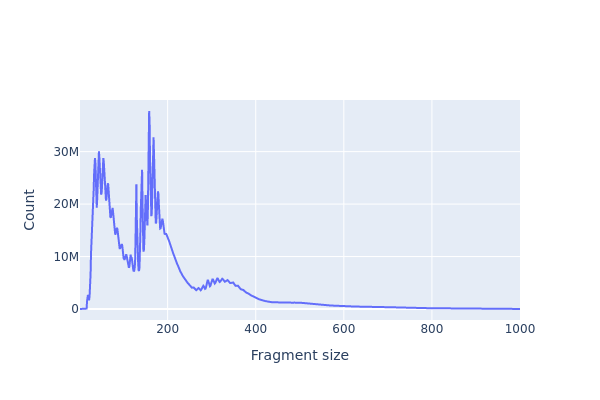

In [4]:
snap.pl.frag_size_distr(adata_subset, interactive=False)

In [5]:
## Genome handling
genome_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/genomes/human"
chr_sizes = pd.read_csv(pjoin(genome_path, 'star/chrNameLength.txt'), sep='\t', header=None)
chr_sizes_dict = dict(zip(chr_sizes[0], chr_sizes[1]))
fasta_path = pjoin(genome_path, 'fasta/genome.fa') if os.path.exists(pjoin(genome_path, 'fasta/genome.fa')) else pjoin(genome_path, 'fasta/genome.fa.gz')
gtf_path = pjoin(genome_path, 'genes/genes.gtf') if os.path.exists(pjoin(genome_path, 'genes/genes.gtf')) else pjoin(genome_path, 'genes/genes.gtf.gz')

genome = snap.genome.Genome(fasta=pjoin(genome_path, fasta_path),
                            annotation=pjoin(genome_path, gtf_path),
                            chrom_sizes=chr_sizes_dict)

In [7]:
snap.metrics.tsse(adata_subset, genome, n_jobs=16) # about 10-20mins
#snap.pl.tsse(adata_subset, interactive=False) no 'n_fragment'

In [17]:
#snap.pp.add_tile_matrix(adata_subset, bin_size=5000)
snap.pp.select_features(adata_subset, n_features=50000)

2025-07-14 12:25:49 - INFO - Selected 50000 features.


/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



CPU times: user 27min 39s, sys: 3min 56s, total: 31min 36s
Wall time: 20min 50s


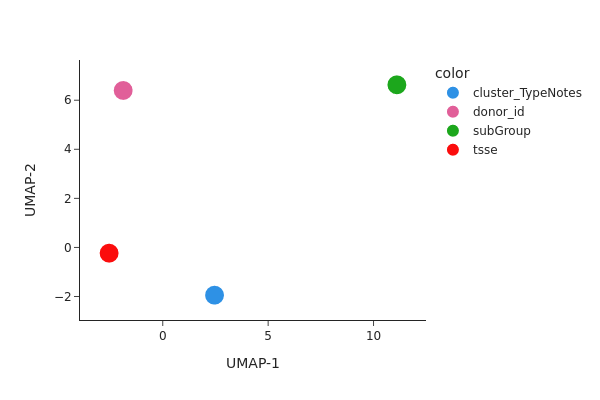

In [10]:
%%time
snap.tl.spectral(adata_subset)
snap.pp.mnc_correct(adata_subset, batch="donor_id")
snap.tl.umap(adata_subset, use_rep="X_spectral_mnn")
snap.pl.umap(adata_subset, color=["subGroup", "donor_id", "cluster_TypeNotes", "tsse"], interactive=False)
#adata_subset.close()

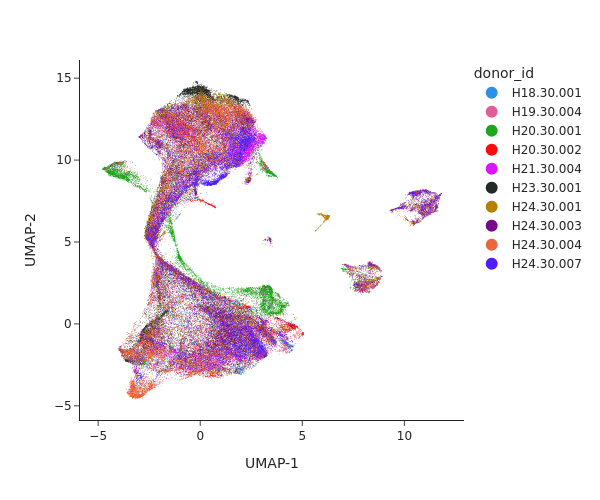

In [16]:
snap.pl.umap(adata_subset, color="donor_id", interactive=False, height=500)

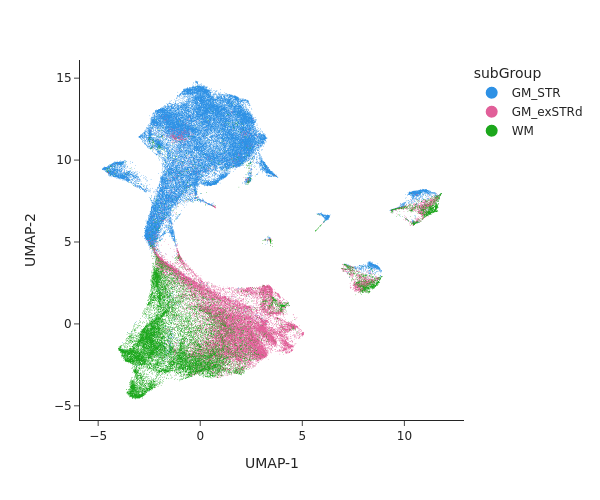

In [17]:
snap.pl.umap(adata_subset, color="subGroup", interactive=False, height=500)

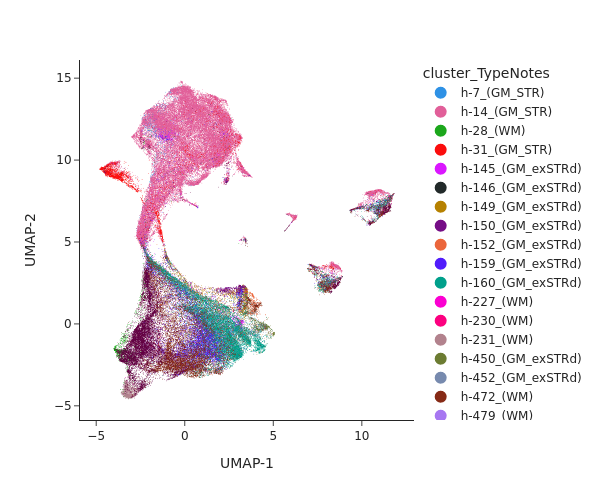

In [18]:
snap.pl.umap(adata_subset, color="cluster_TypeNotes", interactive=False, height=500)

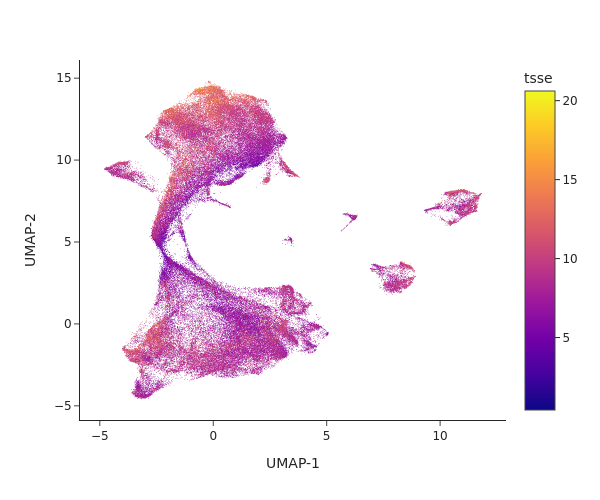

In [19]:
snap.pl.umap(adata_subset, color="tsse", interactive=False, height=500)

In [9]:
adata_subset

AnnDataSet object with n_obs x n_vars = 122168 x 608609 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/Astro_atac_h5ad/astro_atac.h5ads'
contains 204 AnnData objects with keys: '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/21b13da435317922136516f4ea4e27943907579c.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/3f8802c4845985e8290a1041514906b38de36452.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/bfc3295e69e7e7b19c7e1676e9b9cd28b2ee822c.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/45f1425ec9e97b7f278b6308116a90a77d2e82ed.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_

In [20]:
adata_subset.close()

### bigwigs

In [ ]:
## bigwigs directorys
root_directory = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup'
groupby = 'subGroup'

out_dir=os.path.join(root_directory, f'{groupby}_bigwig_TSSnorm')
os.makedirs(out_dir, exist_ok=True)

##
## Genome handling
genome_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/genomes/human"
chr_sizes = pd.read_csv(pjoin(genome_path, 'star/chrNameLength.txt'), sep='\t', header=None)
chr_sizes_dict = dict(zip(chr_sizes[0], chr_sizes[1]))
fasta_path = pjoin(genome_path, 'fasta/genome.fa') if os.path.exists(pjoin(genome_path, 'fasta/genome.fa')) else pjoin(genome_path, 'fasta/genome.fa.gz')
gtf_path = pjoin(genome_path, 'genes/genes.gtf') if os.path.exists(pjoin(genome_path, 'genes/genes.gtf')) else pjoin(genome_path, 'genes/genes.gtf.gz')

genome = snap.genome.Genome(fasta=pjoin(genome_path, fasta_path),
                            annotation=pjoin(genome_path, gtf_path),
                            chrom_sizes=chr_sizes_dict)

gtf = pybedtools.BedTool(genome.annotation)

# Filter for 'transcript' features
transcripts = gtf.filter(lambda x: x[2] == "transcript")

# Function to generate ±100bp window around TSS
def tss_window(feature):
    if feature.strand == "+":
        tss = feature.start  # 0-based for BED
        start = max(tss - 100, 0)  # ensure non-negative start
        end = tss + 101  # end is exclusive
    else:
        tss = feature.end  # 0-based BED end is exclusive
        start = max(tss - 101, 0)
        end = tss + 100
    gene_id = feature.attrs.get("gene_id", "NA")
    return (feature.chrom, start, end, gene_id, 0, feature.strand)

# Create list of TSS ±100bp intervals
tss_windows = [tss_window(f) for f in transcripts]

# Convert to DataFrame
tss_df = pd.DataFrame(tss_windows, columns=["chrom", "start", "end", "gene_id", "score", "strand"])
tss_df = tss_df.drop_duplicates()
# Convert each row to "chrom:start-end" format
tss_coords = tss_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['end']}", axis=1)
# Convert to list of strings
tss_list = tss_coords.tolist()

##
print("export covering ...")
snap.ex.export_coverage(adata_subset, groupby=groupby, out_dir=out_dir, normalization='CPM', bin_size=10, 
                        counting_strategy='insertion', include_for_norm=tss_list, n_jobs=12)

adata_subset.close()

# ## Compute bigwig
# snap.ex.export_coverage(data, groupby=groupby,out_dir=out_dir,normalization='CPM', bin_size=10, counting_strategy='insertion')


2025-07-13 10:47:50 - INFO - Exporting fragments...


In [ ]:
import os, psutil
process = psutil.Process(os.getpid())
print(f"Memory used: {process.memory_info().rss / 1024 ** 2:.2f} MB")


### call peaks

In [ ]:
adata_subset = snap.read_dataset(root_directory + "/Astro_atac_h5ad/astro_atac.h5ads")

In [4]:
## Genome handling
genome_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/genomes/human"
chr_sizes = pd.read_csv(pjoin(genome_path, 'star/chrNameLength.txt'), sep='\t', header=None)
chr_sizes_dict = dict(zip(chr_sizes[0], chr_sizes[1]))
fasta_path = pjoin(genome_path, 'fasta/genome.fa') if os.path.exists(pjoin(genome_path, 'fasta/genome.fa')) else pjoin(genome_path, 'fasta/genome.fa.gz')
gtf_path = pjoin(genome_path, 'genes/genes.gtf') if os.path.exists(pjoin(genome_path, 'genes/genes.gtf')) else pjoin(genome_path, 'genes/genes.gtf.gz')

genome = snap.genome.Genome(fasta=pjoin(genome_path, fasta_path),
                            annotation=pjoin(genome_path, gtf_path),
                            chrom_sizes=chr_sizes_dict)

groupby = 'subGroup'

In [5]:
snap.tl.macs3(adata_subset, groupby=groupby, n_jobs=12)

## Export peaks
peak_tables={}
for k in adata_subset.uns['macs3'].keys():
    if 'dict' in str(type(adata_subset.uns['macs3'][k])):
        peak_tables[k]=list(adata_subset.uns['macs3'][k].values())[0]
    else:
        peak_tables[k]=adata_subset.uns['macs3'][k]

df = snap.tl.merge_peaks(peak_tables,
                        dict(zip(adata_subset.uns['reference_sequences']['reference_seq_name'],adata_subset.uns['reference_sequences']['reference_seq_length'])))
df.write_csv(os.path.join(root_directory,f"{groupby}_by_peaks.csv"))
merged_df=pd.DataFrame(list(df['Peaks'].to_pandas().str.split('\:|\-')),columns=['chrom','start','end'])
merged_df.to_csv(os.path.join(root_directory,f"merged_peaks.bed"),sep='\t',header=None,index=False)

##
adata_subset.close()

2025-07-13 22:23:34 - INFO - Exporting fragments...
2025-07-13 23:22:38 - INFO - Calling peaks...
100%|██████████| 3/3 [9:47:37<00:00, 11752.36s/it]  
/scratch/fast/1676085/ipykernel_2275439/3530772885.py:5: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  for k in adata_subset.uns['macs3'].keys():
/scratch/fast/1676085/ipykernel_2275439/3530772885.py:6: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  if 'dict' in str(type(adata_subset.uns['macs3'][k])):
/scratch/fast/1676085/ipykernel_2275439/3530772885.py:9: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  peak_tables[k]=adata_subset.uns['macs3'][k]
/scratch/fast/1676085/ipykerne

### Identify DARs (Differentially Accessible Regions)

In [2]:
adata_subset = snap.read_dataset(root_directory + "/Astro_atac_h5ad/astro_atac.h5ads")
adata_subset

AnnDataSet object with n_obs x n_vars = 122168 x 608609 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/Astro_atac_h5ad/astro_atac.h5ads'
contains 204 AnnData objects with keys: '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/21b13da435317922136516f4ea4e27943907579c.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/3f8802c4845985e8290a1041514906b38de36452.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/bfc3295e69e7e7b19c7e1676e9b9cd28b2ee822c.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/h5ad/45f1425ec9e97b7f278b6308116a90a77d2e82ed.h5ad', '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_

In [3]:
peaks = pd.read_csv(root_directory + "/subGroup_by_peaks.csv")
print(peaks.head())

                      Peaks     WM  GM_STR  GM_exSTRd
0  GL000009.2:114171-114672  False   False       True
1    GL000194.1:21903-22404  False    True       True
2    GL000194.1:21158-21659  False   False       True
3    GL000194.1:24959-25460   True    True       True
4    GL000194.1:24273-24774   True    True       True


In [4]:
%%time
peak_mat = snap.pp.make_peak_matrix(adata_subset, use_rep=peaks['Peaks'], counting_strategy="insertion") ## peak_file="your_bed_file_.bed"
peak_mat

/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


CPU times: user 54min 4s, sys: 4min 8s, total: 58min 13s
Wall time: 13min 20s


AnnData object with n_obs × n_vars = 122168 × 348543
    obs: 'sample', 'Group', 'Cluster', 'cluster_TypeNotes', 'subGroup', 'anatomical_region', 'anatomical_region_merged', 'donor_id', 'tsse'

In [13]:
peak_mat.write_h5ad(root_directory + "/astro_peak_mat_Insertion.h5ad")

... storing 'sample' as categorical
... storing 'Group' as categorical
... storing 'Cluster' as categorical
... storing 'cluster_TypeNotes' as categorical
... storing 'subGroup' as categorical
... storing 'anatomical_region' as categorical
... storing 'anatomical_region_merged' as categorical
... storing 'donor_id' as categorical


In [5]:
sub = peak_mat.X[1:100, 1:100]
print(sub.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 2 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [18]:
adata_subset.close()

#### quick-and-dirty method to identify marker regions for each subGroup (does not consider the variations across cells)

In [11]:
print(peak_mat)                  
print(peak_mat.var_names[:5])   

AnnData object with n_obs × n_vars = 122168 × 348543
    obs: 'sample', 'Group', 'Cluster', 'cluster_TypeNotes', 'subGroup', 'anatomical_region', 'anatomical_region_merged', 'donor_id', 'tsse'
Index(['GL000009.2:114171-114672', 'GL000194.1:21903-22404',
       'GL000194.1:21158-21659', 'GL000194.1:24959-25460',
       'GL000194.1:24273-24774'],
      dtype='object')


In [8]:
%%time
marker_peaks = snap.tl.marker_regions(peak_mat, groupby='subGroup', pvalue=0.05)
snap.pl.regions(peak_mat, groupby='subGroup', peaks=marker_peaks, interactive=False)

ValueError: need at least one array to concatenate

In [9]:
%%time
motifs = snap.tl.motif_enrichment(
    motifs=snap.datasets.cis_bp(unique=True),
    regions=marker_peaks,
    genome_fasta=snap.genome,
)


2025-07-14 15:11:57 - INFO - Fetching 0 sequences ...


FastaNotFoundError: Cannot read FASTA from file <module 'snapatac2.genome' from '/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/snapatac2/genome.py'>

In [10]:
snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=1600, interactive=False)

Exception ignored in: <function Faidx.__del__ at 0x7fa4432ffe20>
Traceback (most recent call last):
  File "/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/pyfaidx/__init__.py", line 893, in __del__
    self.__exit__()
  File "/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/pyfaidx/__init__.py", line 899, in __exit__
    self.file.close()
AttributeError: 'Faidx' object has no attribute 'file'


NameError: name 'motifs' is not defined

#### Regression-based Differential Test (designing a robust background control is crucial for differential analysis)

In [2]:
peak_mat = sc.read_h5ad(root_directory + "/astro_peak_mat_Insertion.h5ad")

In [3]:
peak_mat.obs['subGroup'].value_counts()

subGroup
GM_STR       59506
GM_exSTRd    35961
WM           26701
Name: count, dtype: int64

In [9]:
peaks = pd.read_csv(root_directory + "/subGroup_by_peaks.csv")
print(peaks.head())

                      Peaks     WM  GM_STR  GM_exSTRd
0  GL000009.2:114171-114672  False   False       True
1    GL000194.1:21903-22404  False    True       True
2    GL000194.1:21158-21659  False   False       True
3    GL000194.1:24959-25460   True    True       True
4    GL000194.1:24273-24774   True    True       True


In [ ]:
### upSet Plot of whole peaks across three subGroups

<Figure size 1000x600 with 0 Axes>

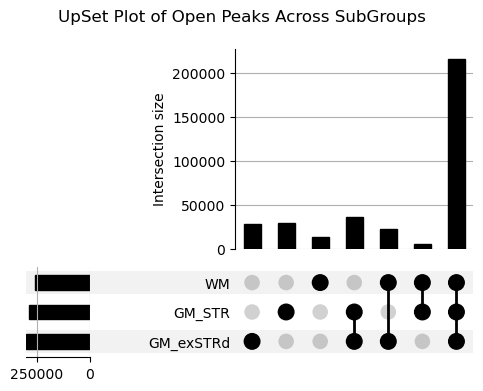

In [10]:
from upsetplot import from_indicators, UpSet
import matplotlib.pyplot as plt

data = from_indicators(indicators=["WM", "GM_STR", "GM_exSTRd"], data=peaks)

plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count").plot()
plt.suptitle("UpSet Plot of Open Peaks Across SubGroups")
plt.show()


In [11]:
peaks_all = pd.read_csv(root_directory + "/../Group_by_peaks.csv") #for whole taxonomy
print(peaks_all.head())

                      Peaks  Astrocyte    SMC  OB FRMD7 GABA  Microglia  \
0  GL000009.2:114168-114669       True  False          False      False   
1  GL000009.2:115001-115502      False  False          False      False   
2      GL000194.1:7949-8450      False  False          False      False   
3    GL000194.1:21900-22401       True  False          False      False   
4    GL000194.1:21201-21702       True  False          False      False   

   SN-VTR GAD2 Dopa  Oligo OPALIN  GPi Shell  STR Cholinergic GABA  \
0             False          True      False                 False   
1             False         False      False                 False   
2             False         False      False                 False   
3             False         False      False                 False   
4             False         False      False                 False   

   SN EBF2 GABA  ...  STRd Cholinergic GABA  ZI-HTH GABA  \
0         False  ...                  False        False   
1       

##### (1) GM_STR vs. WM

In [ ]:
%%time

group1 = "GM_STR"
group2 = "WM"

## peak set selection (open peaks per subGroup)
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

## cell selection
gmstr = peak_mat.obs['subGroup'] == group1
wm = peak_mat.obs['subGroup'] == group2

str_wm_diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=gmstr,
    cell_group2=wm,
    features=peaks_selected,
    min_log_fc=0.5, ## 0.25 by default; logFC 0.585 = FC 1.5
    min_pct=0.1, ## 0.05 by default
)

import polars as pl
str_wm_diff_peaks = str_wm_diff_peaks.filter(pl.col('adjusted p-value') < 0.05)
str_wm_diff_peaks.write_csv(root_directory + "/GMstr_vs_WM_diff_peaks_logfc0.5_pct0.1_padj0.05.csv")
print(str_wm_diff_peaks.head())

2025-07-14 17:36:31 - INFO - Input contains 320586 features, now perform filtering with 'min_log_fc = 0.5' and 'min_pct = 0.1' ...
2025-07-14 17:37:22 - INFO - Testing 9721 features ...
 29%|██▉       | 2828/9721 [35:26<1:24:36,  1.36it/s]

##### (2) GM_STR vs. GM_exSTRd

In [ ]:
%%time

group1 = "GM_STR"
group2 = "GM_exSTRd"

## peak set selection (open peaks per subGroup)
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

## cell selection
gmstr = peak_mat.obs['subGroup'] == group1
gmexstrd = peak_mat.obs['subGroup'] == group2

str_exstrd_diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=gmstr,
    cell_group2=gmexstrd,
    features=peaks_selected,
    min_log_fc=0.5, ## 0.25 by default; logFC 0.585 = FC 1.5
    min_pct=0.1, ## 0.05 by default
)

str_exstrd_diff_peaks = str_exstrd_diff_peaks.filter(pl.col('adjusted p-value') < 0.05)
str_exstrd_diff_peaks.write_csv(root_directory + "/GMstr_vs_GMexstrd_diff_peaks_logfc0.5_pct0.1_padj0.05.csv")
print(str_exstrd_diff_peaks.head())

##### (3) GM_exSTRd vs. WM

In [ ]:
%%time

group1 = "GM_exSTRd"
group2 = "WM"

## peak set selection (open peaks per subGroup)
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

## cell selection
gmexstrd = peak_mat.obs['subGroup'] == group1
wm = peak_mat.obs['subGroup'] == group2

exstrd_wm_diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=gmexstrd,
    cell_group2=wm,
    features=peaks_selected,
    min_log_fc=0.5, ## 0.25 by default; logFC 0.585 = FC 1.5
    min_pct=0.1, ## 0.05 by default
)

exstrd_wm_diff_peaks = exstrd_wm_diff_peaks.filter(pl.col('adjusted p-value') < 0.05)
exstrd_wm_diff_peaks.write_csv(root_directory + "/GMexstrd_vs_WM_diff_peaks_logfc0.5_pct0.1_padj0.05.csv")
print(exstrd_wm_diff_peaks.head())

In [ ]:
snap.pl.regions(
    peak_mat,
    groupby = 'subGroup',
    peaks = {
        group1: str_wm_diff_peaks.filter(pl.col("log2(fold_change)") > 0)['feature name'].to_numpy(),
        group2: str_wm_diff_peaks.filter(pl.col("log2(fold_change)") < 0)['feature name'].to_numpy(),
    },
    interactive = False,
)

### Visualization of peaks/DARs

#### (1) DARs

In [2]:
file_info = {
    "GMstr_vs_WM_diff_peaks_logfc0.5_pct0.1_padj0.05.csv": "GM-STR_vs_WM",
    "GMstr_vs_GMexstrd_diff_peaks_logfc0.5_pct0.1_padj0.05.csv": "GM-STR_vs_GM-exSTRd",
    "GMexstrd_vs_WM_diff_peaks_logfc0.5_pct0.1_padj0.05.csv": "GM-exSTRd_vs_WM",
}

# to save all dfs
dfs = []

for fname, label in file_info.items():
    fpath = os.path.join(root_directory, fname)
    df = pd.read_csv(fpath)
    df["comparison"] = label  
    dfs.append(df)


merged_df = pd.concat(dfs, ignore_index=True)
print(merged_df.head())

           feature name  log2(fold_change)  p-value  adjusted p-value  \
0    chr1:925420-925921          -2.041454      0.0               0.0   
1    chr1:924775-925276          -1.507819      0.0               0.0   
2   chr1:999900-1000401           0.770363      0.0               0.0   
3  chr1:1304629-1305130          -1.050416      0.0               0.0   
4  chr1:2821878-2822379           1.186553      0.0               0.0   

     comparison  
0  GM-STR_vs_WM  
1  GM-STR_vs_WM  
2  GM-STR_vs_WM  
3  GM-STR_vs_WM  
4  GM-STR_vs_WM  


In [13]:
unique_peak_count = merged_df["feature name"].nunique()
print("Number of unique peaks:", unique_peak_count)


Number of unique peaks: 11998


In [14]:
### universe set of DARs (merge 3 1v1 files) -> save to bed
unique_peaks = merged_df["feature name"].unique()


bed_df = pd.DataFrame([x.replace('"','') for x in unique_peaks])  
bed_df = bed_df[0].str.extract(r'(?P<chr>[^:]+):(?P<start>\d+)-(?P<end>\d+)')

bed_df["start"] = bed_df["start"].astype(int)
bed_df["end"] = bed_df["end"].astype(int)


bed_df[["chr", "start", "end"]].to_csv(root_directory + "/results/unique_DAR_peaks_humanAstro.bed", sep="\t", header=False, index=False)

print("BED file saved as unique_peaks.bed")

BED file saved as unique_peaks.bed


<Figure size 1000x600 with 0 Axes>

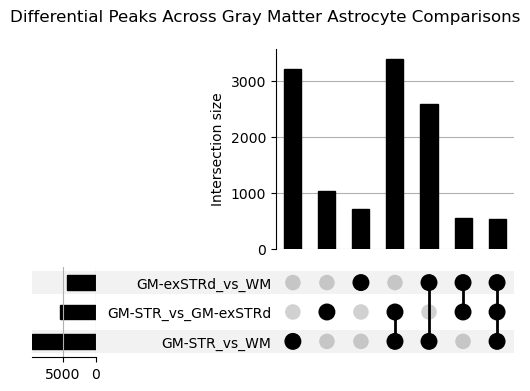

In [4]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# summarize that each peak appears in which comparison
peak_to_comparisons = (
    merged_df.groupby("feature name")["comparison"]
    .apply(set)  
    .reset_index()
)

memberships = peak_to_comparisons["comparison"].tolist()
data = from_memberships(memberships)

plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count").plot()
plt.suptitle("Differential Peaks Across Human BG Astrocyte Comparisons")
plt.show()


<Figure size 1000x600 with 0 Axes>

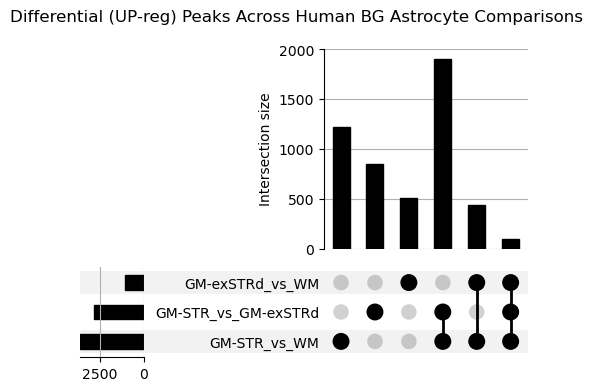

In [5]:
merged_df_up = merged_df[merged_df["log2(fold_change)"] > 0]

peak_to_comparisons = (
    merged_df_up.groupby("feature name")["comparison"]
    .apply(set)  
    .reset_index()
)

memberships = peak_to_comparisons["comparison"].tolist()
data = from_memberships(memberships)

plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count").plot()
plt.suptitle("Differential (UP-reg) Peaks Across Human BG Astrocyte Comparisons")
plt.show()


<Figure size 1000x600 with 0 Axes>

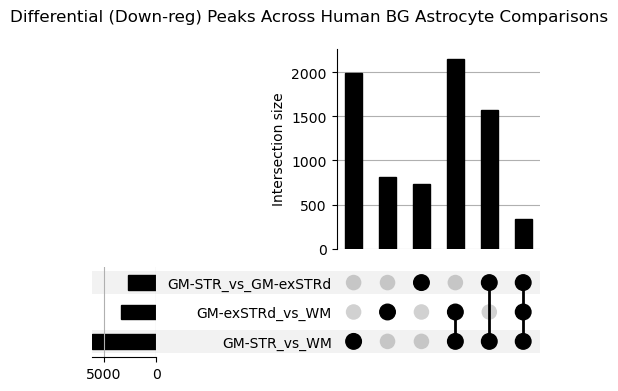

In [7]:
merged_df_down = merged_df[merged_df["log2(fold_change)"] < 0]

peak_to_comparisons = (
    merged_df_down.groupby("feature name")["comparison"]
    .apply(set)  
    .reset_index()
)

memberships = peak_to_comparisons["comparison"].tolist()
data = from_memberships(memberships)

plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count").plot()
plt.suptitle("Differential (Down-reg) Peaks Across Human BG Astrocyte Comparisons")
plt.show()
